In [1]:
#conda install -c conda-forge watermark

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression

import scipy
from scipy import stats

import statsmodels
import statsmodels.api as sm

import watermark

%load_ext watermark

%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: 

watermark  : 2.2.0
numpy      : 1.19.2
sklearn    : 0.23.2
scipy      : 1.5.2
matplotlib : 3.3.2
statsmodels: 0.12.2
pandas     : 1.1.3



# Moving Average Models (MA)

In [3]:
def MA(epsilon, theta, mean=0):
    theta = list(theta)
    N = len(epsilon)
    theta0 = np.array([1] + theta)
    theta0 = theta0[::-1] # Invert the order
    q = len(theta0)
    
    X = []
    for i in range(N-q):
        X.append(np.dot(theta0, epsilon[i:i+q])+mean)
    
    return np.array(X)

In [4]:
N = 500
thetas = []
X_MA = []
q_max = 8

epsilon = np.random.normal(size=N)

for q in range(1, q_max+1, 2):
    thetas.append(np.random.random(q))
    X_MA.append(MA(epsilon, thetas[-1]))

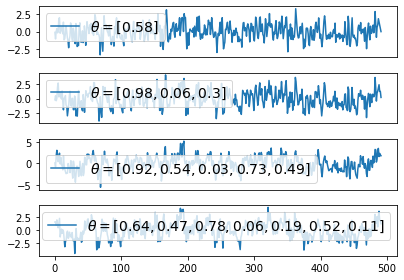

In [5]:
fig, axs = plt.subplots(4, 1)

for i in range(q_max//2):
    axs[i].plot(X_MA[i])
    axs[i].legend([r'$\theta=\left[%s\right]$' % ", ".join(thetas[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

In [6]:
def pearson(x, y):
    meanx = x.mean()
    meany = y.mean()
    stdx = x.std()
    stdy = y.std()
    return np.mean((x - meanx) * (y - meany)) / (stdx * stdy)

In [7]:
def acf(x, lag=40):
    return np.array([1] + [pearson(x[:-i], x[i:]) for i in range(1, lag)])

In [8]:
def acf_ci(acfv, n, alpha=0.05):
    se = [1 / np.sqrt(n)]
    se.extend(np.sqrt((1+2*np.cumsum(np.power(acfv[1:-1], 2)))/n))
    se = np.array(se)
    
    se *= stats.norm.ppf(1-alpha/2.)
    return se

In [9]:
def plot_acf(x, lag=40, alpha=0.05):
    acf_val = acf(x, lag)
    
    plt.vlines(range(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('ACF')
    
    # Determine confidence interval
    ci = acf_ci(acf_val, len(x), alpha)
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

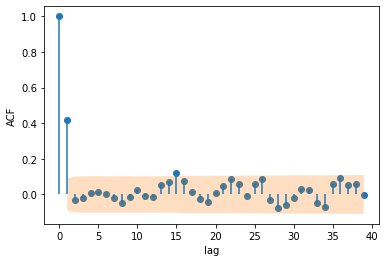

In [10]:
plot_acf(X_MA[0])

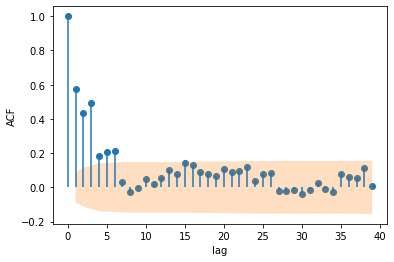

In [11]:
plot_acf(X_MA[-1])

# Autoregressive Model (AR)

In [12]:
def AR(epsilon, phi, drift=0):
    phi = list(phi)
    N = len(epsilon)

    phi0 = np.array([1] + phi)
    phi0 = phi0[::-1] # Invert the order
    p = len(phi0)
    
    X = epsilon.copy()

    for i in range(p, N):
        X[i-1] = np.dot(X[i-p:i], phi0) + drift
        
    return np.array(X)

In [13]:
N = 500
phis = []
X_AR = []
p_max = 8

epsilon = np.random.normal(size=N)

for p in range(1, p_max+1, 2):
    phis.append(np.random.normal(0, .2, p))
    X_AR.append(AR(epsilon, phis[-1]))

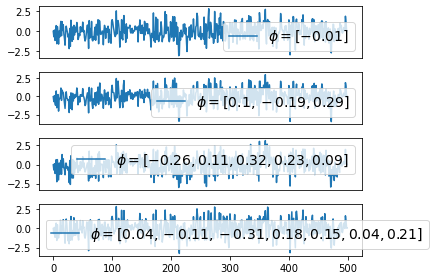

In [14]:
fig, axs = plt.subplots(4, 1)

for i in range(p_max//2):
    axs[i].plot(X_AR[i])
    axs[i].legend([r'$\phi=\left[%s\right]$' % ", ".join(phis[i].round(2).astype('str'))], prop={'size': 14})
    axs[i].get_xaxis().set_visible(False)
    
axs[-1].get_xaxis().set_visible(True)
fig.tight_layout()

In [15]:
def rolling(x, order):
    npoints = x.shape[0]
    running = []
    
    for i in range(npoints-order):
        running.append(x[i:i+order])
        
    return np.array(running)

In [16]:
def pacf(x, lag=40):
    y = []
    
    for i in range(3, lag + 2):
        windows = rolling(x.flatten(), i)

        xt = windows[:, -1] # Current values are at the end
        xt_l = windows[:, 0] # Lagged values are at 0
        inter = windows[:, 1:-1] # Intermediate values are in between 1 and -1

        lm = LinearRegression(fit_intercept=False).fit(inter, xt)
        xt_fit = lm.predict(inter)

        lm = LinearRegression(fit_intercept=False).fit(inter, xt_l)
        xt_l_fit = lm.predict(inter)

        y.append(pearson(xt - xt_fit, xt_l - xt_l_fit))
    
    # Pad the array with the two missing values
    pacf_1 = acf(x, 2)[1]
    return np.array([1, pacf_1] +  y)

In [17]:
def plot_pacf(x, alpha=0.05, lag=40):
    pacf_val = pacf(x, lag)
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('PACF')
    
    # Determine confidence interval
    ci = acf_ci(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

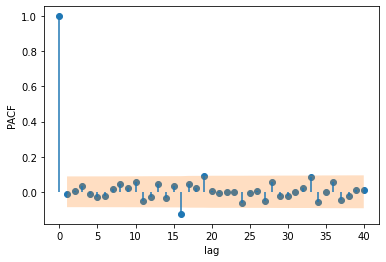

In [18]:
plot_pacf(X_AR[0])

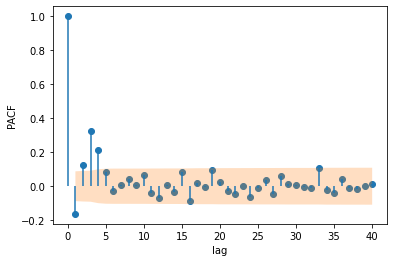

In [19]:
plot_pacf(X_AR[-2])

# ARIMA

In [20]:
def differentiate(values, d=1):
    # First value is required so that we can recover the original values with np.cumsum
    x = np.concatenate([[values[0]], values[1:]-values[:-1]])

    if d == 1:
        return x
    else:    
        return differentiate(x, d - 1)

In [21]:
def integrate(values, d=1):
    x = np.cumsum(values)
    
    if d == 1:
        return x
    else:
        
        return integrate(x, d-1)

In [22]:
class ARIMA(LinearRegression):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = differentiate(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features = rolling(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = rolling(np.r_[np.zeros(self.p), x], self.p)
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = integrate(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

In [23]:
ILI = pd.read_csv('CDC.csv')

In [24]:
ILI.head(2)

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,Expected,Threshold,All Deaths,Pneumonia Deaths,Influenza Deaths
0,2012,1,8.479120,8.15718,8.49104,51102,4323,10
1,2012,2,8.343472,8.22181,8.55556,50962,4245,7


In [25]:
ILI['date'] = ILI['Year']+ILI['Week']/52.

In [26]:
ILI['date'].head(3)

0    2012.019231
1    2012.038462
2    2012.057692
Name: date, dtype: float64

In [27]:
values = ILI['Percent of Deaths Due to Pneumonia and Influenza'].values
diff = differentiate(values, 1)

In [28]:
values

array([ 8.47912019,  8.34347161,  8.37090767,  8.44845803,  8.14033247,
        8.10968027,  8.17970076,  8.29206948,  8.40621868,  8.6815136 ,
        8.57244206,  8.34955788,  7.97523143,  8.01182038,  7.70626121,
        7.62230039,  7.50472943,  7.43763603,  7.15921495,  7.11762703,
        7.06448508,  6.83526702,  6.63876243,  6.74745661,  6.82665626,
        6.86242594,  6.44705278,  6.60788156,  6.55709154,  6.33022298,
        6.62020906,  6.57042983,  6.58330429,  6.42521594,  6.52389793,
        6.66766685,  6.82490659,  6.72440911,  6.78498409,  6.71175967,
        6.91486039,  6.9522227 ,  7.08672967,  6.84822359,  6.88751525,
        7.06816811,  6.98192271,  7.58078534,  7.72958051,  7.8970425 ,
        8.25634118,  8.98714821, 10.16324114, 11.05025084, 11.10566522,
       10.62711747, 10.0729383 ,  9.4957621 ,  9.36018522,  8.87754339,
        8.73211829,  8.47473516,  8.51015674,  8.19489524,  8.17678065,
        7.98947984,  7.81074863,  7.76761743,  7.4700639 ,  7.26

In [29]:
diff

array([ 8.47912019e+00, -1.35648585e-01,  2.74360589e-02,  7.75503616e-02,
       -3.08125554e-01, -3.06522062e-02,  7.00204955e-02,  1.12368719e-01,
        1.14149195e-01,  2.75294923e-01, -1.09071537e-01, -2.22884181e-01,
       -3.74326452e-01,  3.65889511e-02, -3.05559170e-01, -8.39608171e-02,
       -1.17570958e-01, -6.70934060e-02, -2.78421081e-01, -4.15879156e-02,
       -5.31419503e-02, -2.29218059e-01, -1.96504590e-01,  1.08694180e-01,
        7.91996480e-02,  3.57696784e-02, -4.15373163e-01,  1.60828783e-01,
       -5.07900165e-02, -2.26868561e-01,  2.89986078e-01, -4.97792301e-02,
        1.28744581e-02, -1.58088345e-01,  9.86819901e-02,  1.43768920e-01,
        1.57239737e-01, -1.00497480e-01,  6.05749767e-02, -7.32244152e-02,
        2.03100720e-01,  3.73623099e-02,  1.34506968e-01, -2.38506080e-01,
        3.92916646e-02,  1.80652854e-01, -8.62453968e-02,  5.98862625e-01,
        1.48795174e-01,  1.67461993e-01,  3.59298678e-01,  7.30807033e-01,
        1.17609293e+00,  

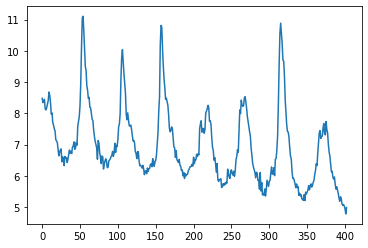

In [30]:
plt.plot(values)

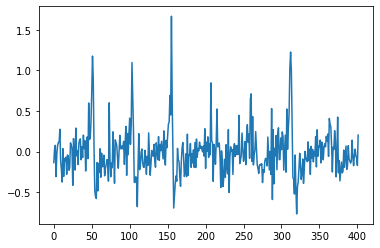

In [31]:
plt.plot(diff[1:])

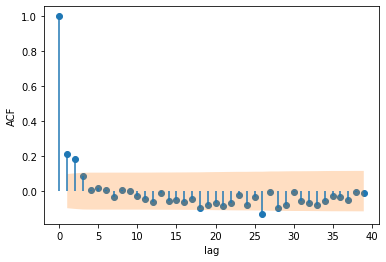

In [32]:
plot_acf(diff)

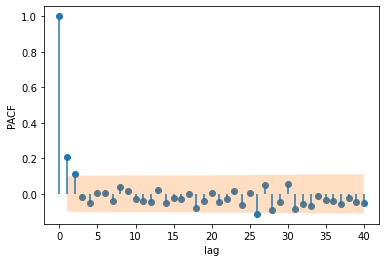

In [33]:
plot_pacf(diff)

In [34]:
#after getting parameters
model = ARIMA(2, 0, 2)
pred = model.fit_predict(values)

C:\Users\DELL-POJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass fit_intercept=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [35]:
pred

array([ 2.04721227,  7.72115496,  7.10696757,  7.3813594 ,  8.34236171,
        7.8883495 ,  7.82999421,  8.09521787,  8.23154414,  8.34081071,
        8.65789294,  8.44063418,  8.01065662,  7.5958461 ,  7.77752739,
        7.53046985,  7.38298105,  7.38996209,  7.32153707,  6.99832511,
        6.98462933,  7.05316406,  6.73884081,  6.50946176,  6.78600985,
        6.9677184 ,  6.93651629,  6.33435124,  6.57205688,  6.71046668,
        6.28135291,  6.73534296,  6.76024479,  6.60964831,  6.44508908,
        6.57982793,  6.85311681,  6.99249178,  6.77849367,  6.80003442,
        6.76238118,  7.00470465,  7.08543552,  7.15469139,  6.81829587,
        6.82220236,  7.20314951,  7.03004224,  7.76563648,  7.98939642,
        7.88926302,  8.3477679 ,  9.25012962, 10.63841378, 11.42492091,
       10.89618754,  9.88554715,  9.21352109,  8.71550138,  8.81337523,
        8.41047414,  8.26173091,  8.15759291,  8.25469771,  7.9408763 ,
        7.89565073,  7.80754497,  7.55602026,  7.60496965,  7.27

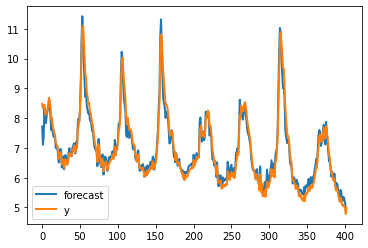

In [36]:
ax = plt.subplot(111)
ax.plot(pred[1:], label='forecast', lw=2)
ax.plot(values, label='y', lw=2)
plt.legend()

C:\Users\DELL-POJ\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


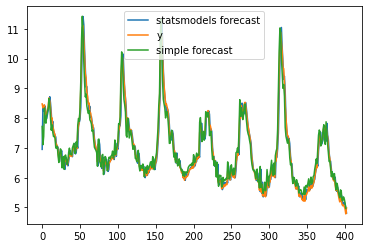

In [37]:
results = sm.tsa.ARIMA(values, (2, 0, 2)).fit()

fig, ax = plt.subplots(1, 1)
pred_sm = results.plot_predict(ax=ax)
ax.plot(pred[1:])
plt.legend(['statsmodels forecast', 'y', 'simple forecast'])

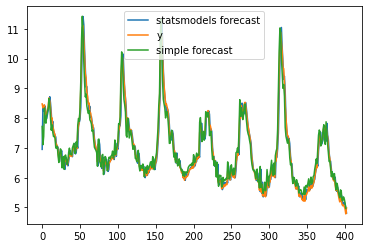

In [38]:
pred_sm

In [39]:
results

In [40]:
len(pred), len(values)

(403, 403)

In [41]:
ILI['prediksi'] = pred

In [42]:
ILI.tail(10)

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,Expected,Threshold,All Deaths,Pneumonia Deaths,Influenza Deaths,date,prediksi
393,2019,29,5.186623,5.36965,5.70843,50476,2612,6,2019.557692,5.422431
394,2019,30,5.328236,5.32184,5.66062,50223,2669,7,2019.576923,5.325169
395,2019,31,5.276241,5.28544,5.62423,49884,2626,6,2019.596154,5.590172
396,2019,32,5.102758,5.26098,5.59976,49777,2533,7,2019.615385,5.555654
397,2019,33,5.054571,5.24883,5.58761,48194,2428,8,2019.634615,5.237564
398,2019,34,5.085333,5.24916,5.58794,46172,2343,5,2019.653846,5.223756
399,2019,35,5.031743,5.26200,5.60078,44577,2231,12,2019.673077,5.354499
400,2019,36,4.951483,5.28715,5.62593,43078,2122,11,2019.692308,5.287949
401,2019,37,4.781635,5.32427,5.66305,38857,1845,13,2019.711538,5.161342
402,2019,38,4.985358,5.37284,5.71162,28684,1421,9,2019.730769,4.965077


In [43]:
forcast_ = model.forecast(values,7)

In [44]:
forcast_

array([ 2.04721227,  7.72115496,  7.10696757,  7.3813594 ,  8.34236171,
        7.8883495 ,  7.82999421,  8.09521787,  8.23154414,  8.34081071,
        8.65789294,  8.44063418,  8.01065662,  7.5958461 ,  7.77752739,
        7.53046985,  7.38298105,  7.38996209,  7.32153707,  6.99832511,
        6.98462933,  7.05316406,  6.73884081,  6.50946176,  6.78600985,
        6.9677184 ,  6.93651629,  6.33435124,  6.57205688,  6.71046668,
        6.28135291,  6.73534296,  6.76024479,  6.60964831,  6.44508908,
        6.57982793,  6.85311681,  6.99249178,  6.77849367,  6.80003442,
        6.76238118,  7.00470465,  7.08543552,  7.15469139,  6.81829587,
        6.82220236,  7.20314951,  7.03004224,  7.76563648,  7.98939642,
        7.88926302,  8.3477679 ,  9.25012962, 10.63841378, 11.42492091,
       10.89618754,  9.88554715,  9.21352109,  8.71550138,  8.81337523,
        8.41047414,  8.26173091,  8.15759291,  8.25469771,  7.9408763 ,
        7.89565073,  7.80754497,  7.55602026,  7.60496965,  7.27

In [45]:
len(forcast_)

410

In [46]:
forcast_[403:]

array([5.58175295, 5.98634703, 6.28242676, 6.49717798, 6.65304809,
       6.76617517, 6.84828066])

In [47]:
ILI2 = ILI[['Year', 'Week', 'Percent of Deaths Due to Pneumonia and Influenza', 'prediksi']]

In [48]:
ILI2.tail(10)

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,prediksi
393,2019,29,5.186623,5.422431
394,2019,30,5.328236,5.325169
395,2019,31,5.276241,5.590172
396,2019,32,5.102758,5.555654
397,2019,33,5.054571,5.237564
398,2019,34,5.085333,5.223756
399,2019,35,5.031743,5.354499
400,2019,36,4.951483,5.287949
401,2019,37,4.781635,5.161342
402,2019,38,4.985358,4.965077


In [49]:
for i in forcast_[403:]:
    print(i)

5.581752948159213
5.9863470339132565
6.282426760729
6.4971779835464565
6.653048090091687
6.7661751745998515
6.84828066215006


In [50]:
columns = list(ILI2)
year = 2019
Week = 38
forecast_data = []
for i in forcast_[403:]:
    Week +=1
    values = [year, Week, np.nan, i]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    print(a_dictionary)
    forecast_data.append(a_dictionary)

{'Year': 2019, 'Week': 39, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 5.581752948159213}
{'Year': 2019, 'Week': 40, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 5.9863470339132565}
{'Year': 2019, 'Week': 41, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 6.282426760729}
{'Year': 2019, 'Week': 42, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 6.4971779835464565}
{'Year': 2019, 'Week': 43, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 6.653048090091687}
{'Year': 2019, 'Week': 44, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 6.7661751745998515}
{'Year': 2019, 'Week': 45, 'Percent of Deaths Due to Pneumonia and Influenza': nan, 'prediksi': 6.84828066215006}


In [51]:
ILI2 = ILI2.append(forecast_data, True)

In [52]:
ILI2

,Year,Week,Percent of Deaths Due to Pneumonia and Influenza,prediksi
0,2012,1,8.479120,2.047212
1,2012,2,8.343472,7.721155
2,2012,3,8.370908,7.106968
3,2012,4,8.448458,7.381359
4,2012,5,8.140332,8.342362
...,...,...,...,...
405,2019,41,NaN,6.282427
406,2019,42,NaN,6.497178
407,2019,43,NaN,6.653048
408,2019,44,NaN,6.766175
